# Tutorial 3: Five modality integration
In this tutorial, we demonstrate how to use SCIGMA to analyze a Mouse Brain Spatial-Mux-seq dataset. This tutorial can be run in under 25 minutes on a GPU-enabled computer.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from SCIGMA_multi import *
from sklearn.neighbors import kneighbors_graph 
from data import load_data, preprocessing, build_network, feature_graph, clr_normalize_each_cell
import numpy as np
import matplotlib.pyplot as plt
from utils import clustering, separation_scores, compactness_scores, lsi
import scanpy as sc
import gc
import pandas as pd
import anndata as ad
from scipy import sparse

# Load data

To run this tutorial, make sure to download the Spatial Mux-seq dataset from here: 
- Epigenomics modalities: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM8494157
- RNA: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM8494158 
- Protein: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM8494159 
Modify the filepaths accordingly to match the downloaded data filepaths.

In [ ]:
# Filepaths (modify)
sp_path = '<Downloaded data directory>'
file_RNA = "5M_20um_RNA/matrix.mtx.gz"
file_RNA_feat = "5M_20um_RNA/features.tsv.gz"
file_RNA_barcode = "5M_20um_RNA/barcodes.tsv.gz"
file_RNA_spatial = "5M_20um_spatial/tissue_positions_list.csv"
file_Protein = "5M_20um_Protein/matrix.mtx.gz"
file_Protein_feat = "5M_20um_Protein/features.tsv.gz"
file_Protein_barcode = "5M_20um_Protein/barcodes.tsv.gz"
file_Protein_spatial = "5M_20um_spatial/tissue_positions_list.csv"
file_ATAC = "GSM8494157_5M_20um_ATAC.fragments.tsv.gz"
file_HISTac = "GSM8494157_5M_20um_H3K27ac.fragments.tsv.gz"
file_HISTme3 = "GSM8494157_5M_20um_H3K27me3.fragments.tsv.gz"
file_protein = "GSM8494159_5M_20um_protein.tar.gz"

In [ ]:
# RNA
rna =  ad.read_mtx(sp_path+file_RNA).transpose()
rna_feat = pd.read_csv(sp_path+file_RNA_feat, sep='\t', header=None)
rna_barcode = pd.read_csv(sp_path+file_RNA_barcode, sep='\t', header=None)
rna_spatial = pd.read_csv(sp_path+file_RNA_spatial, sep=',', header=None)
rna.obs_names = rna_barcode[0]
rna.var_names = rna_feat[1]
rna.var['ensembl'] = list(rna_feat[0])
coord = pd.merge(rna_barcode, rna_spatial[[0,2,3]], left_on=0, right_on=0)
rna.obs['x'] = list(coord[2])
rna.obs['y'] = list(coord[3])
rna.obsm['spatial'] = rna.obs[['x','y']].to_numpy()

In [ ]:
# Protein
protein =  ad.read_mtx(sp_path+file_Protein).transpose()
protein_feat = pd.read_csv(sp_path+file_Protein_feat, sep='\t', header=None)
protein_barcode = pd.read_csv(sp_path+file_Protein_barcode, sep='\t', header=None)
protein_spatial = pd.read_csv(sp_path+file_Protein_spatial, sep=',', header=None)
protein.obs_names = protein_barcode[0]
protein.var_names = protein_feat[0]
protein.var['names'] = list(protein_feat[0])
coord = pd.merge(protein_barcode, protein_spatial[[0,2,3]], left_on=0, right_on=0)
protein.obs['x'] = list(coord[2])
protein.obs['y'] = list(coord[3])
protein.obsm['spatial'] = protein.obs[['x','y']].to_numpy()

In [ ]:
# ATAC
atac_lsi = pd.read_csv(sp_path+"preprocessed_data/ATAC_LSI.csv")
atac_lsi['barcode'] = atac_lsi['Unnamed: 0'].str.split('#').str[1]
atac_lsi.set_index('barcode', inplace=True)
atac_lsi = atac_lsi.drop(columns = ['Unnamed: 0'])
atac_adata = ad.AnnData(atac_lsi)
atac_adata.obsm['spatial'] = rna[atac_adata.obs_names].obsm['spatial']
atac_adata.obsm['X_lsi'] = atac_adata.X
atac_adata.write_h5ad(sp_path+'ATAC_preprocessed.h5ad')

/tmp/ipykernel_1199733/3282441018.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac_adata = ad.AnnData(atac_lsi)


In [ ]:
# H3K27me3
me3_lsi = pd.read_csv(sp_path+"preprocessed_data/H3K27me3_LSI.csv")
me3_lsi['barcode'] = me3_lsi['Unnamed: 0'].str.split('#').str[1]
me3_lsi.set_index('barcode', inplace=True)
me3_lsi = me3_lsi.drop(columns = ['Unnamed: 0'])
me3_adata = ad.AnnData(me3_lsi)
me3_adata.obsm['spatial'] = rna[me3_adata.obs_names].obsm['spatial']
me3_adata.obsm['X_lsi'] = me3_adata.X
me3_adata.write_h5ad(sp_path+'H3K27me3_preprocessed.h5ad')

/tmp/ipykernel_1199733/2960487857.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  me3_adata = ad.AnnData(me3_lsi)


In [ ]:
# H3K27ac
ac_lsi = pd.read_csv(sp_path+"preprocessed_data/H3K27ac_LSI.csv")
ac_lsi['barcode'] = ac_lsi['Unnamed: 0'].str.split('#').str[1]
ac_lsi.set_index('barcode', inplace=True)
ac_lsi = ac_lsi.drop(columns = ['Unnamed: 0'])
ac_adata = ad.AnnData(ac_lsi)
ac_adata.obsm['spatial'] = rna[ac_adata.obs_names].obsm['spatial']
ac_adata.obsm['X_lsi'] = ac_adata.X
ac_adata.write_h5ad(sp_path+'H3K27ac_preprocessed.h5ad')

/tmp/ipykernel_1199733/117465859.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ac_adata = ad.AnnData(ac_lsi)


In [6]:
# load preprocessed ATAC, histone
atac_adata = ad.read_h5ad(sp_path+'ATAC_preprocessed.h5ad')
histme3_adata = ad.read_h5ad(sp_path+'H3K27me3_preprocessed.h5ad')
histac_adata = ad.read_h5ad(sp_path+'H3K27ac_preprocessed.h5ad')

# Preprocessing

Preprocess each modality's data and store in a dictionary output for SCIGMA

In [8]:
# preprocess into dict
shared_cells = list(set(rna.obs_names).intersection(set(atac_adata.obs_names)).intersection(set(histac_adata.obs_names)).intersection(set(histme3_adata.obs_names)))
data_dict = preprocessing(rna[shared_cells], atac_adata[shared_cells], datatype='Multiplex',n_neighbors=18, feat_neighbors=6)

Preprocessing anndatas


/users/schang59/anaconda/glue/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/users/schang59/anaconda/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/schang59/anaconda/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/schang59/anaconda/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/schang59/anaconda/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Vari

Constructing spatial graphs
Constructing feature graphs
Feature graph 1
Feature graph 1 finished
Feature graph 2
Feature graph 2 finished


In [9]:
# histone modalities
shared_cells = list(set(data_dict['adata_omics1'].obs_names).intersection(set(data_dict['adata_omics2'].obs_names)).intersection(set(histac_adata.obs_names)).intersection(set(histme3_adata.obs_names)))
histac_adata = histac_adata[shared_cells]
histme3_adata = histme3_adata[shared_cells]
# feat
print("processing feat1")
histac_adata.obsm['feat'] = np.nan_to_num(histac_adata.obsm['X_lsi'],nan=0).copy()

print("processing feat2")
histme3_adata = histme3_adata[histac_adata.obs_names]
histme3_adata.obsm['feat'] = np.nan_to_num(histme3_adata.obsm['X_lsi'],nan=0).copy()

# spatial graph
print("processing spatial")
cell_position_omics2 = histac_adata.obsm['spatial']
adj_omics2 = build_network(cell_position_omics2, n_neighbors=18)
histac_adata.uns['adj_spatial'] = adj_omics2
cell_position_omics2 = histme3_adata.obsm['spatial']
adj_omics2 = build_network(cell_position_omics2, n_neighbors=18)
histme3_adata.uns['adj_spatial'] = adj_omics2

# feature graph
print("processing feature spatial")
feature_graph_omics1, feature_graph_omics2 = feature_graph(histac_adata, histme3_adata, k=6)
histac_adata.obsm['adj_feature'], histme3_adata.obsm['adj_feature'] = feature_graph_omics1, feature_graph_omics2

processing feat1
processing feat2
processing spatial
processing feature spatial
Feature graph 1
Feature graph 1 finished
Feature graph 2
Feature graph 2 finished


In [10]:
# protein modality
shared_cells = list(set(data_dict['adata_omics1'].obs_names).intersection(set(data_dict['adata_omics2'].obs_names)).intersection(set(histac_adata.obs_names)).intersection(set(histme3_adata.obs_names)))
protein = clr_normalize_each_cell(protein[shared_cells])
protein.layers['logcounts'] = protein.X
sc.pp.scale(protein)
sc.pp.pca(protein, n_comps=30)
protein.obsm['feat'] = protein.obsm['X_pca'].copy()

# spatial graph
cell_position_omics = protein.obsm['spatial']
adj_omics = build_network(cell_position_omics, n_neighbors=18)
protein.uns['adj_spatial'] = adj_omics

# feature graph
feature_graph_omics=kneighbors_graph(protein.obsm['feat'], 6, mode="connectivity", metric="correlation", include_self=False, n_jobs=-1)
protein.obsm['adj_feature'] = feature_graph_omics

In [11]:
data_dict['adata_omics3'] = histac_adata[shared_cells]
data_dict['adata_omics4'] = histme3_adata[shared_cells]
data_dict['adata_omics5'] = protein[shared_cells]

## Visualize modality specific data

fitting ...
  |======================================================================| 100%


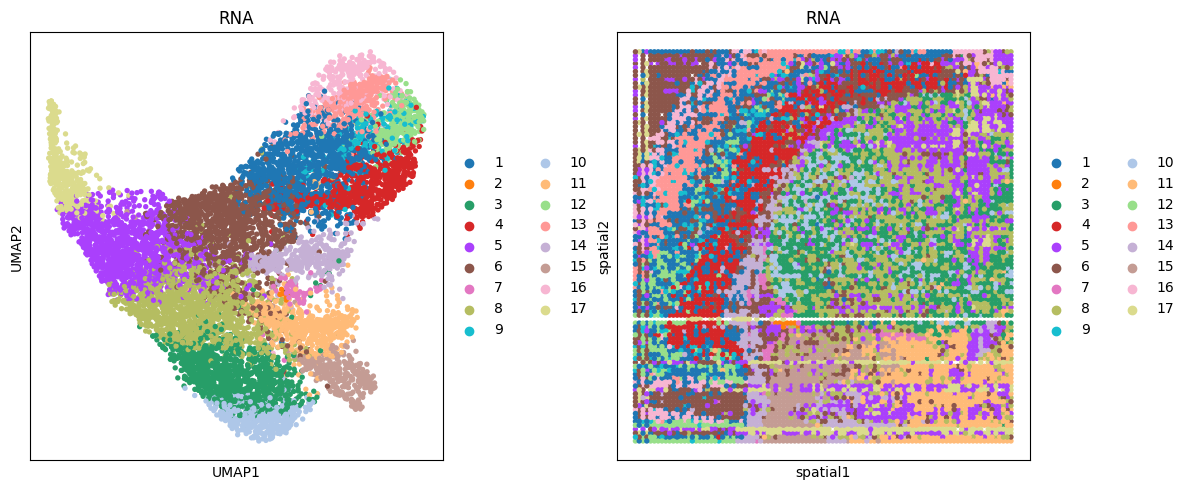

In [43]:
# mRNA
clustering(data_dict['adata_omics1'], key='feat', add_key='RNA', n_clusters=17, use_pca=False)
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(data_dict['adata_omics1'], use_rep='feat', n_neighbors=10)
sc.tl.umap(data_dict['adata_omics1'])

sc.pl.umap(data_dict['adata_omics1'], color='RNA', ax=ax_list[0], title='RNA', s=60, show=False)
sc.pl.embedding(data_dict['adata_omics1'], basis='spatial', color='RNA', ax=ax_list[1], title='RNA', s=60, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

fitting ...
  |======================================================================| 100%


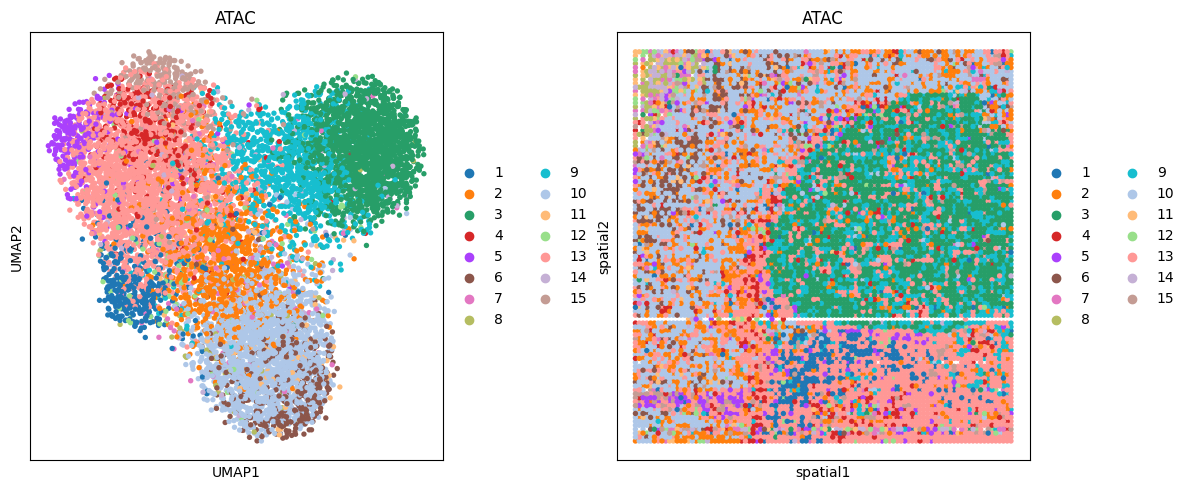

In [49]:
# ATAC
clustering(data_dict['adata_omics2'], key='X_lsi', add_key='ATAC', n_clusters=15,use_pca=False)
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(data_dict['adata_omics2'], use_rep='feat', n_neighbors=10)
sc.tl.umap(data_dict['adata_omics2'])

sc.pl.umap(data_dict['adata_omics2'], color='ATAC', ax=ax_list[0], title='ATAC', s=60, show=False)
sc.pl.embedding(data_dict['adata_omics2'], basis='spatial', color='ATAC', ax=ax_list[1], title='ATAC', s=60, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

fitting ...
  |======================================================================| 100%


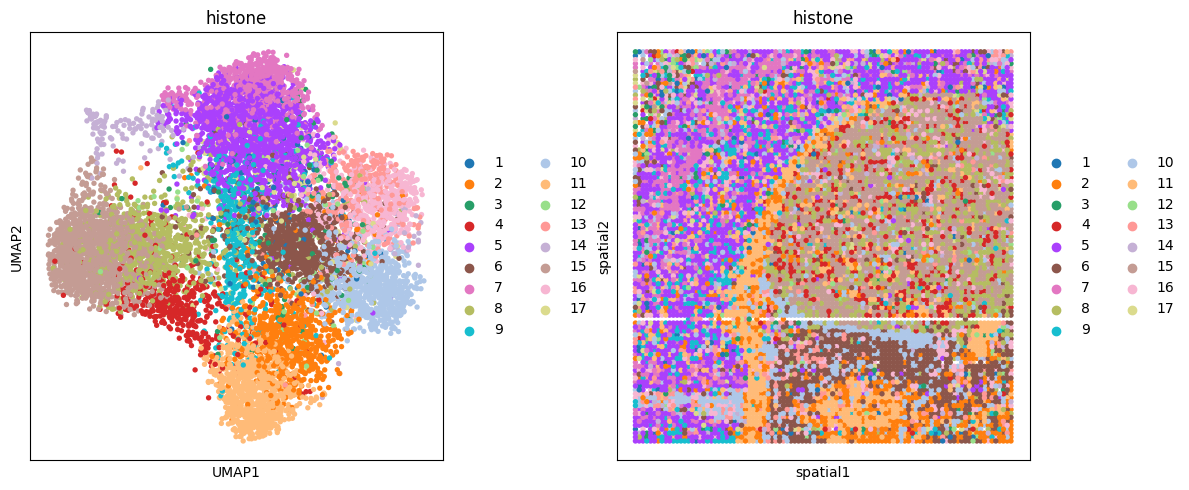

In [45]:
# histone (ac)
clustering(data_dict['adata_omics3'], key='feat', add_key='histone', n_clusters=17, use_pca=False)
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(data_dict['adata_omics3'], use_rep='feat', n_neighbors=10)
sc.tl.umap(data_dict['adata_omics3'])

sc.pl.umap(data_dict['adata_omics3'], color='histone', ax=ax_list[0], title='histone', s=60, show=False)
sc.pl.embedding(data_dict['adata_omics3'], basis='spatial', color='histone', ax=ax_list[1], title='histone', s=60, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

fitting ...
  |======================================================================| 100%


Exception ignored from cffi callback <function _processevents at 0x7f05fb6ff790>:
Traceback (most recent call last):
  File "/users/schang59/anaconda/glue/lib/python3.8/site-packages/rpy2/rinterface_lib/callbacks.py", line 277, in _processevents
    try:
KeyboardInterrupt: 


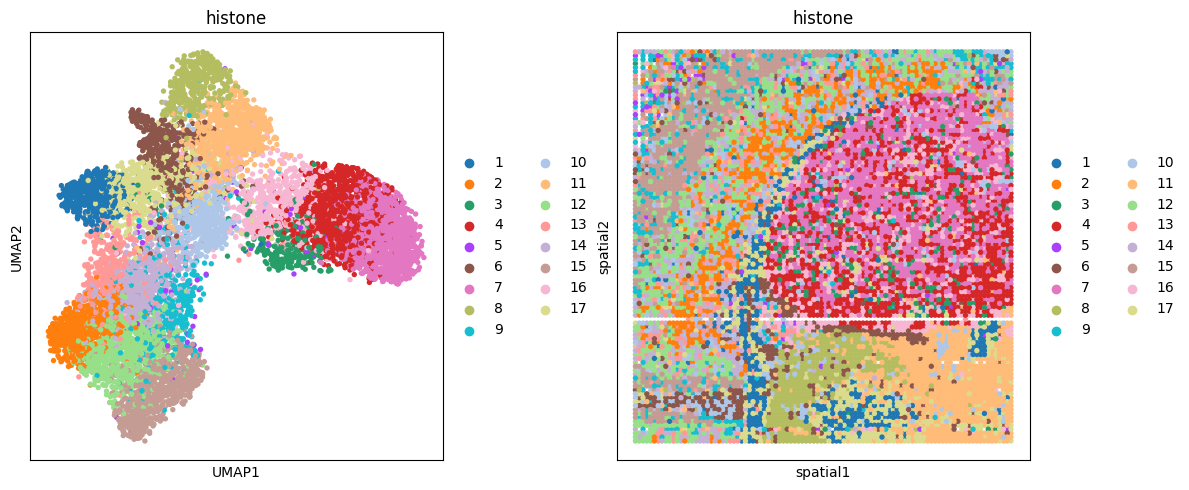

In [46]:
# histone(me3)
clustering(data_dict['adata_omics4'], key='feat', add_key='histone', n_clusters=17,use_pca=False)
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(data_dict['adata_omics4'], use_rep='feat', n_neighbors=10)
sc.tl.umap(data_dict['adata_omics4'])

sc.pl.umap(data_dict['adata_omics4'], color='histone', ax=ax_list[0], title='histone', s=60, show=False)
sc.pl.embedding(data_dict['adata_omics4'], basis='spatial', color='histone', ax=ax_list[1], title='histone', s=60, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

fitting ...
  |                                                                      |   0%

Exception ignored from cffi callback <function _processevents at 0x7f05fb6ff790>:
Traceback (most recent call last):
  File "/users/schang59/anaconda/glue/lib/python3.8/site-packages/rpy2/rinterface_lib/callbacks.py", line 277, in _processevents
    try:
KeyboardInterrupt: 


  |======================================================================| 100%


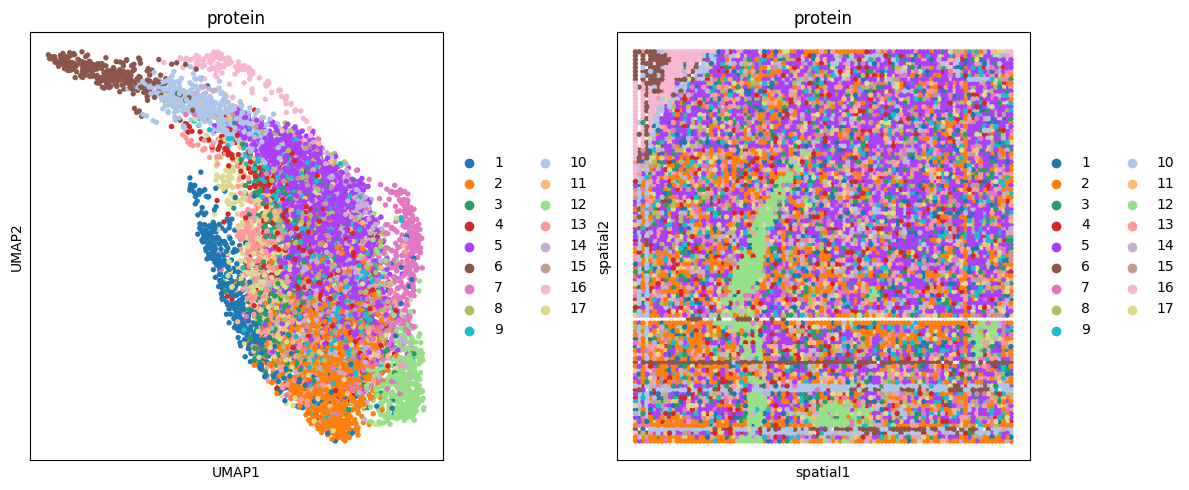

In [47]:
# protein
clustering(data_dict['adata_omics5'], key='feat', add_key='protein', n_clusters=17,use_pca=False)
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(data_dict['adata_omics5'], use_rep='feat', n_neighbors=10)
sc.tl.umap(data_dict['adata_omics5'])

sc.pl.umap(data_dict['adata_omics5'], color='protein', ax=ax_list[0], title='protein', s=60, show=False)
sc.pl.embedding(data_dict['adata_omics5'], basis='spatial', color='protein', ax=ax_list[1], title='protein', s=60, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

## Model Training

In [134]:
seed = 2025
contrastive_weights = {'adata_omics1': 1e-1, 'adata_omics2': 1e-1, 'adata_omics3': 1e-1, 'adata_omics4': 1e-1, 'adata_omics5': 1e-1}
recon_weights = {'adata_omics1': 1, 'adata_omics2': 1, 'adata_omics3': 1, 'adata_omics4': 1, 'adata_omics5': 1}
model = SCIGMA_multi(data_dict, seed_num=seed, dim_output=40, device=torch.device('cuda:0'), clr_weight=0.3, batch_size=3000, learning_rate=1e-3, contrastive_weights=contrastive_weights, recon_weights=recon_weights, connectivities=None)

Creating adjacency matrices
Model ready for training!


In [ ]:
output = model.train(1500)

In [136]:
adata_combined = data_dict['adata_omics1'].copy()
adata_combined.uns['emb_latent'] = output['emb_latent']
adata_combined.uns['emb_recon'] = output['emb_recon']
adata_combined.obsm['emb_combined'] = output['emb_latent_combined']
adata_combined.obs['invtau'] = output['invtau']
adata_combined.obs['tau'] = output['tau']
adata_combined.uns['attention'] = output['attention']

/users/schang59/anaconda/glue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [137]:
# we use mcluster as clustering tool by default.
tool = 'mclust' # mclust, leiden, and louvain

# clustering
if tool == 'mclust':
    clustering(adata_combined, key='emb_combined', add_key='SCIGMA', n_clusters=17, method=tool, use_pca=False)
elif tool in ['leiden', 'louvain']:
    clustering(adata_combined, key='emb_combined', add_key='SCIGMA', n_clusters=17, method=tool, start=0.1, end=2.0, increment=0.01)

fitting ...
  |======================================================================| 100%


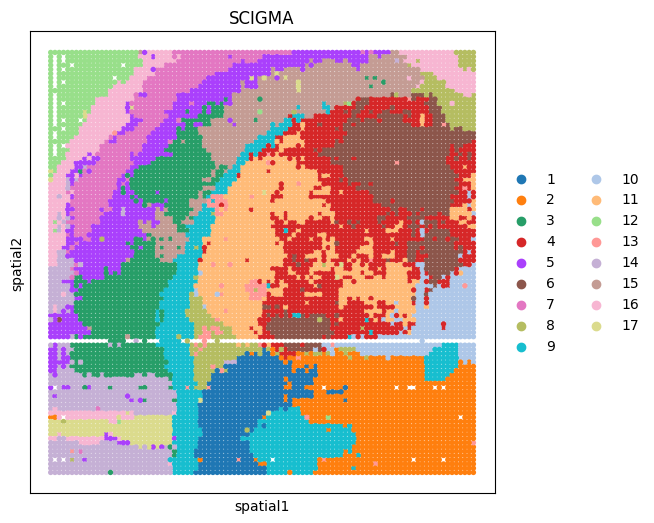

In [138]:
# visualization
import scanpy as sc
fig, ax_list = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.embedding(adata_combined, basis='spatial', color='SCIGMA', ax=ax_list, title='SCIGMA', s=60, show=False)
plt.gca()
plt.show()

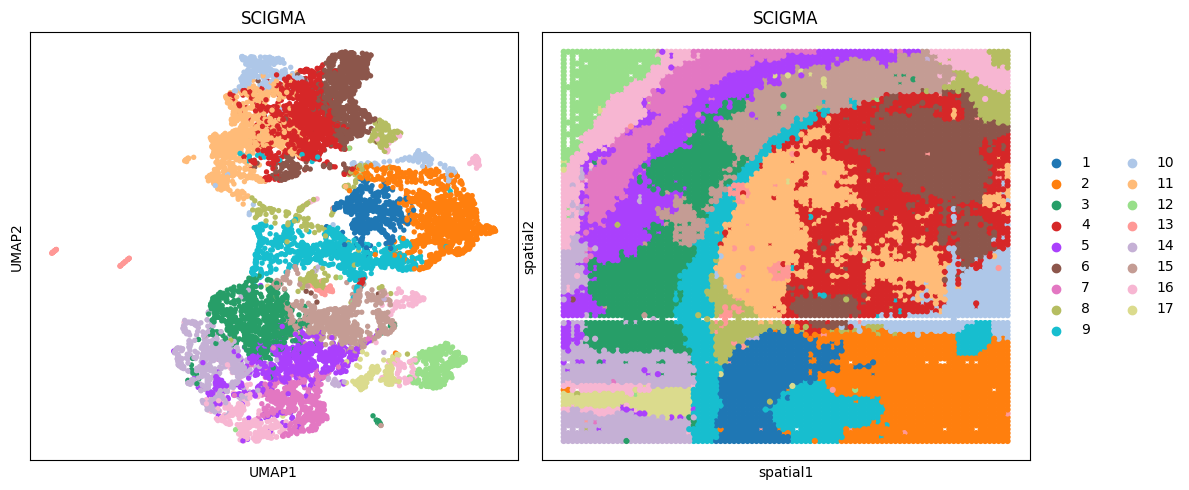

In [139]:
# visualization
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_combined, use_rep='emb_combined', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SCIGMA', ax=ax_list[0], title='SCIGMA', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SCIGMA', ax=ax_list[1], title='SCIGMA', s=80, show=False)

ax_list[0].get_legend().remove()
plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:
# uncertainty visualization
sc.pl.embedding(adata_combined, 
                basis='spatial', 
                color=['invtau'], 
                title=['Uncertainty'], s=50, show=False)
plt.gca()
plt.show()